In [1]:
import numpy as np
from spec_id import Gen_spec, Median_w_Error_cont, Calzetti
import matplotlib.pyplot as plt
from matplotlib import gridspec
from vtl.Readfile import Readfile
from vtl.Photo import Photometry
import pandas as pd
from glob import glob
from astropy.io import fits, ascii
from astropy.table import Table
from scipy.interpolate import interp1d
import os
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

In [2]:
galDB = pd.read_pickle('../data/upd_galDB.pkl')
bfDB = pd.read_pickle('../chidat/BF_fullfit.pkl')
metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [18]:
goods_s=Table.read(hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',format='ascii').to_pandas()
goods_n=Table.read(hpath + 'Clear_data/goodsn_mosaic/goodsn_3dhstP.cat',format='ascii').to_pandas()


In [31]:
IDS = []
IDN = []
for i in galDB.index:
    if galDB.gids[i][0] == 's':
        IDS.append(int(galDB.gids[i][1:]))
    if galDB.gids[i][0] == 'n':
        IDN.append(int(galDB.gids[i][1:]))

In [36]:
sphot = goods_s[goods_s.id.isin(IDS)]
nphot = goods_n[goods_n.id.isin(IDN)]

In [41]:
f_s = []
e_s = []
f_n = []
e_n = []

for i in sphot.columns:
    if i[0:2] == 'f_':
        f_s.append(i)
    if i[0:2] == 'e_':
        e_s.append(i)

for i in nphot.columns:
    if i[0:2] == 'f_':
        f_n.append(i)
    if i[0:2] == 'e_':
        e_n.append(i)       

In [51]:
s_trans = np.loadtxt('/Users/Vince.ec/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Eazy/goodss_3dhst.v4.1.translate',dtype='str').T
n_trans = np.loadtxt('/Users/Vince.ec/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Eazy/goodsn_3dhst.v4.1.translate',dtype='str').T

In [86]:
extra = [105,201,202,183,184,193,197]
u = 0

f_num_s = []
for i in f_s:
    try:
        f_num_s.append(int(s_trans[1][np.argwhere(s_trans[0] == i)[0][0]][1:]))
    except:
        f_num_s.append(extra[u])
        u+=1

In [83]:
f_num_n = []
for i in f_n:
    f_num_n.append(int(n_trans[1][np.argwhere(n_trans[0] == i)[0][0]][1:]))

In [89]:
wv,fl = np.load('/Users/Vince.ec/fsps_models_for_fit/fsps_spec/m0.019_a2.0_dt0_spec.npy')
er = np.ones(len(wv))

In [95]:
phot = Photometry(wv,fl,er,1)

s_eff_wv = []
n_eff_wv = []

for i in f_num_s:
    phot.Get_Sensitivity(i)
    phot.Photo()
    s_eff_wv.append(phot.eff_wv)
    
for i in f_num_n:
    phot.Get_Sensitivity(i)
    phot.Photo()
    n_eff_wv.append(phot.eff_wv)

In [109]:
s_photo_list = {'gids':sphot.id} 
n_photo_list = {'gids':nphot.id} 

In [110]:
for i in range(len(f_s)):
    s_photo_list[f_s[i]] = sphot[f_s[i]].values
    s_photo_list[e_s[i]] = sphot[e_s[i]].values

for i in range(len(f_n)):
    n_photo_list[f_n[i]] = nphot[f_n[i]].values
    n_photo_list[e_n[i]] = nphot[e_n[i]].values

In [111]:
sphotdb = pd.DataFrame(s_photo_list)
nphotdb = pd.DataFrame(n_photo_list)

In [122]:
effwv_list_s = {'gids' : 'eff_wv'}
effwv_list_n = {'gids' : 'eff_wv'}

In [123]:
for i in range(len(s_eff_wv)):
    effwv_list_s[f_s[i]] = [s_eff_wv[i]]
    effwv_list_s[e_s[i]] = [s_eff_wv[i]]

for i in range(len(n_eff_wv)):
    effwv_list_n[f_n[i]] = [n_eff_wv[i]]
    effwv_list_n[e_n[i]] = [n_eff_wv[i]]

In [125]:
sphotdb = sphotdb.append(pd.DataFrame(effwv_list_s),ignore_index=False)
nphotdb = nphotdb.append(pd.DataFrame(effwv_list_n),ignore_index=False)

In [62]:
sphotdb.to_pickle('../data/south_phot.pkl')
nphotdb.to_pickle('../data/north_phot.pkl')

In [6]:
sphotdb = pd.read_pickle('../data/south_phot.pkl')
nphotdb = pd.read_pickle('../data/north_phot.pkl')

In [7]:
sf_list=[]
for i in sphotdb.columns:
    if i[0] == 'f':
        sf_list.append(i)
        
nf_list=[]
for i in nphotdb.columns:
    if i[0] == 'f':
        nf_list.append(i)

In [5]:
def Calzetti2(Av,lam):
    lam = lam * 1E-4
    Rv=4.05
    k = 2.659*(-1.857 +1.04/(lam)) + Rv
    cal = 10**(-0.4*k*Av/Rv)    
    
    return cal

In [158]:
def Plot(BFDB,idx,photdb,f_list):
#         sp = Gen_spec(galDB.gids[i],galDB.z_grism[i],minwv=8500)
#         mp,ap,tp = Get_params(galDB,i)
#         wv,fl = np.load('/Users/Vince.ec/fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(mp,ap,tp))
    if photdb['f_F098M'][int(BFDB.gids[idx][1:])-1] > 0:
        rshift =galDB[galDB.gids == BFDB.gids[idx]].z_grism.values[0]

        if BFDB.bftau[idx] == 0:
            wv,fl = np.load('/Users/Vince.ec/fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(
                BFDB.bfZ[idx], BFDB.bft[idx], 0))
        else:
            wv,fl = np.load('/Users/Vince.ec/fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(
                    BFDB.bfZ[idx], BFDB.bft[idx], BFDB.bftau[idx]))

        er = np.ones(len(wv))
        dust = Calzetti(BFDB.bfd[idx],wv)
        dust2 = Calzetti2(BFDB.bfd[idx],wv)

        for ii in range(len(dust)):
            if wv[ii] > 6300:
                dust[ii]=dust2[ii] 

        fl *= dust
        phot = Photometry(wv*(1+rshift),fl,er,201)
        phot.Get_Sensitivity()
        phot.Photo()

        Clam = 3E18 / photdb['f_F098M'][0] **2 * 10**((-1.1)/2.5-29)
        fl *= (Clam*photdb['f_F098M'][int(BFDB.gids[idx][1:])-1]/phot.photo)

        phot = Photometry(wv*(1+rshift),fl,er,7)
        phot.Get_Sensitivity()
        phot.Photo()

        #z-850-7, y-098-201, j-125-203, h-160-205

        zlam, z = [phot.eff_wv,phot.photo]

        phot.Get_Sensitivity(201)
        phot.Photo()
        ylam, y =[phot.eff_wv,phot.photo]

        phot.Get_Sensitivity(203)
        phot.Photo()
        jlam, j =[phot.eff_wv,phot.photo]

        phot.Get_Sensitivity(205)
        phot.Photo()
        hlam, h =[phot.eff_wv,phot.photo]

        plt.figure(figsize=[12,6])
        plt.plot(wv*(1+rshift),fl,'k',alpha=0.3)
        for ii in f_list:
            Clam = 3E18 / photdb[ii][0] **2 * 10**((-1.1)/2.5-29)
            if photdb[ii][int(BFDB.gids[i][1:])-1] > 0:
                plt.errorbar(photdb[ii][0],Clam*photdb[ii][int(BFDB.gids[idx][1:])-1],Clam*photdb['e' + ii[1:]][int(BFDB.gids[idx][1:])-1],
                             linestyle='None', marker='s', markersize=10, color='r')

            plt.plot([zlam,ylam,jlam,hlam],[z,y,j,h],'kd',ms=10,zorder=5)
        plt.xlim(7500,17000)
        plt.title(BFDB.gids[idx])

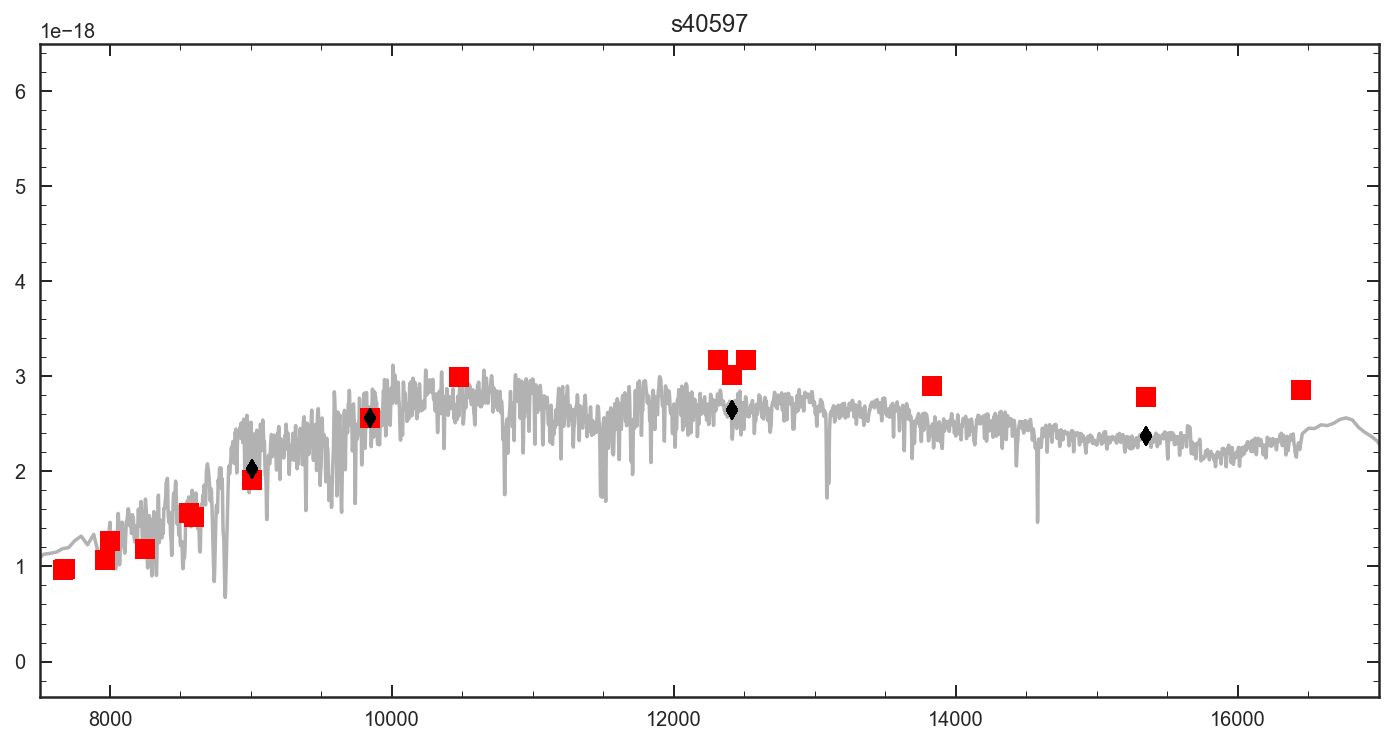

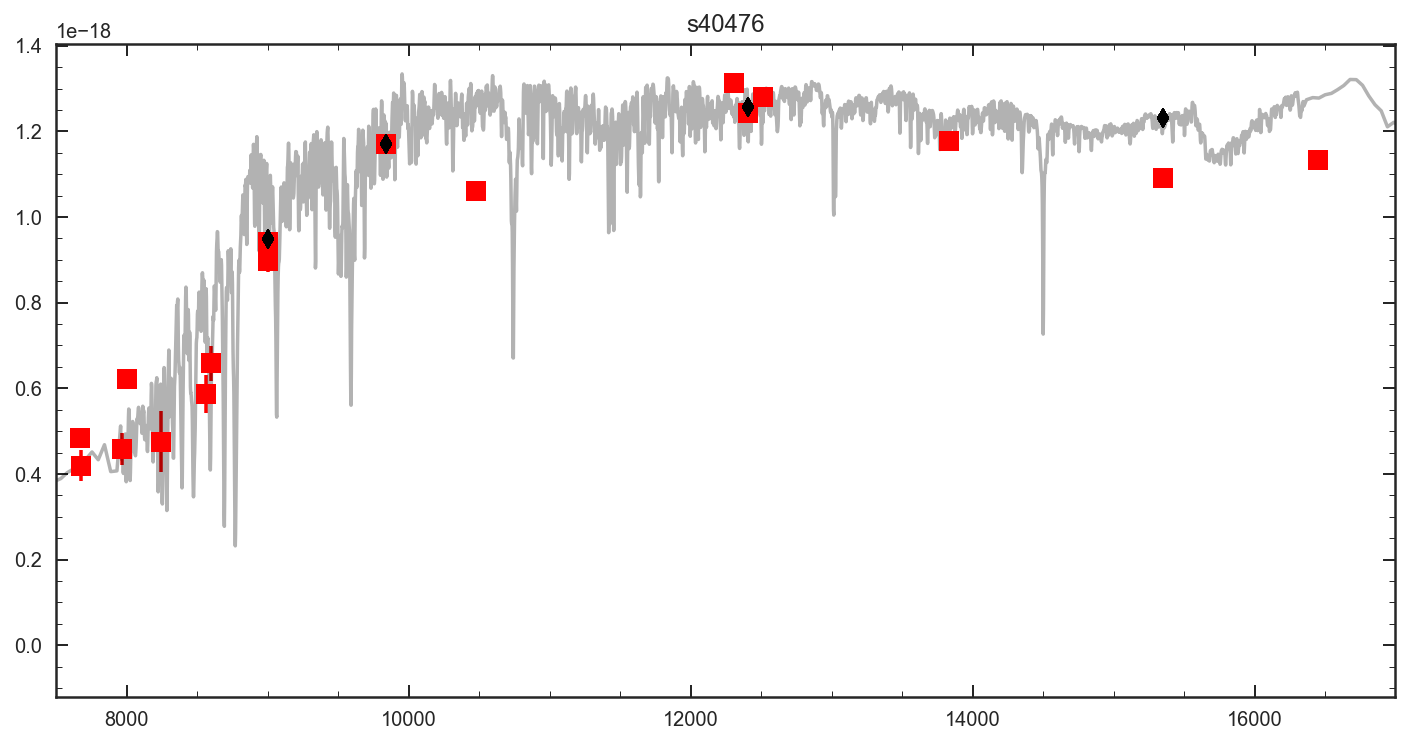

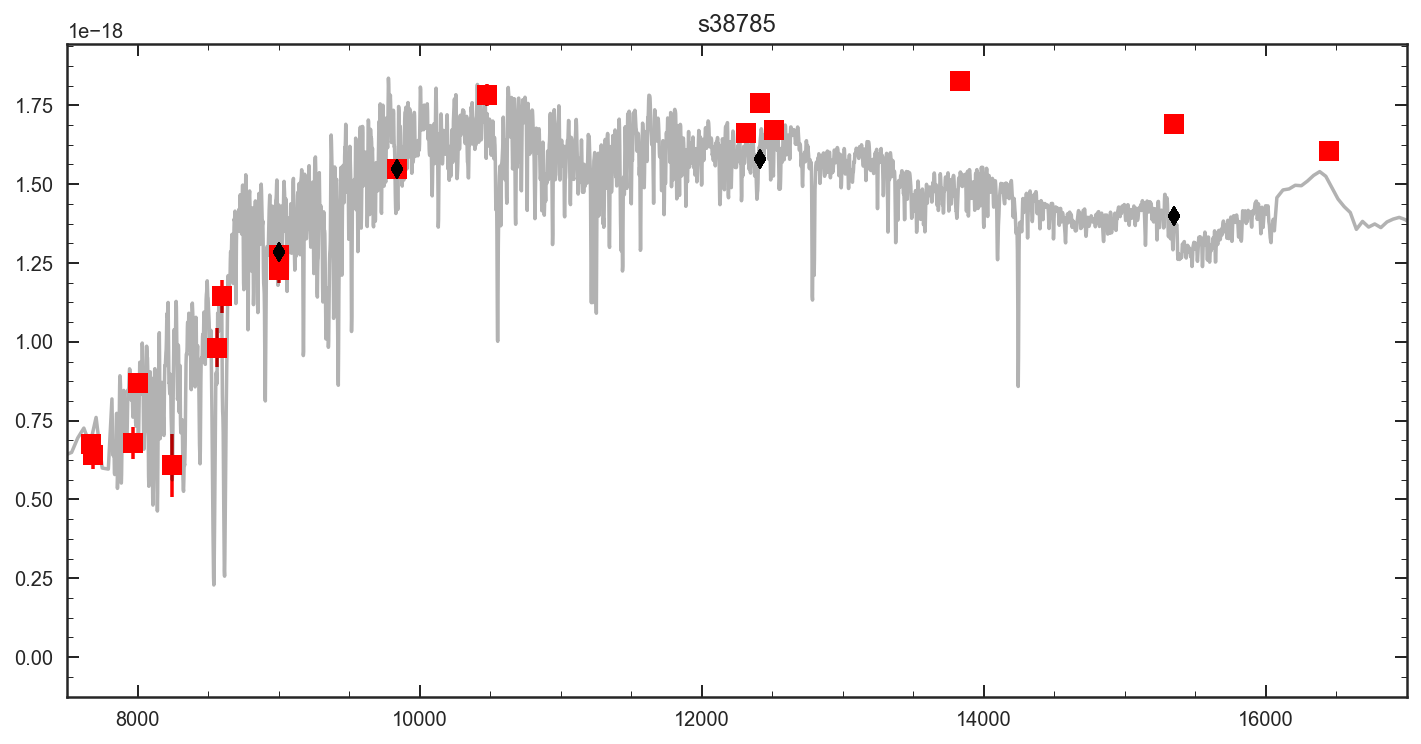

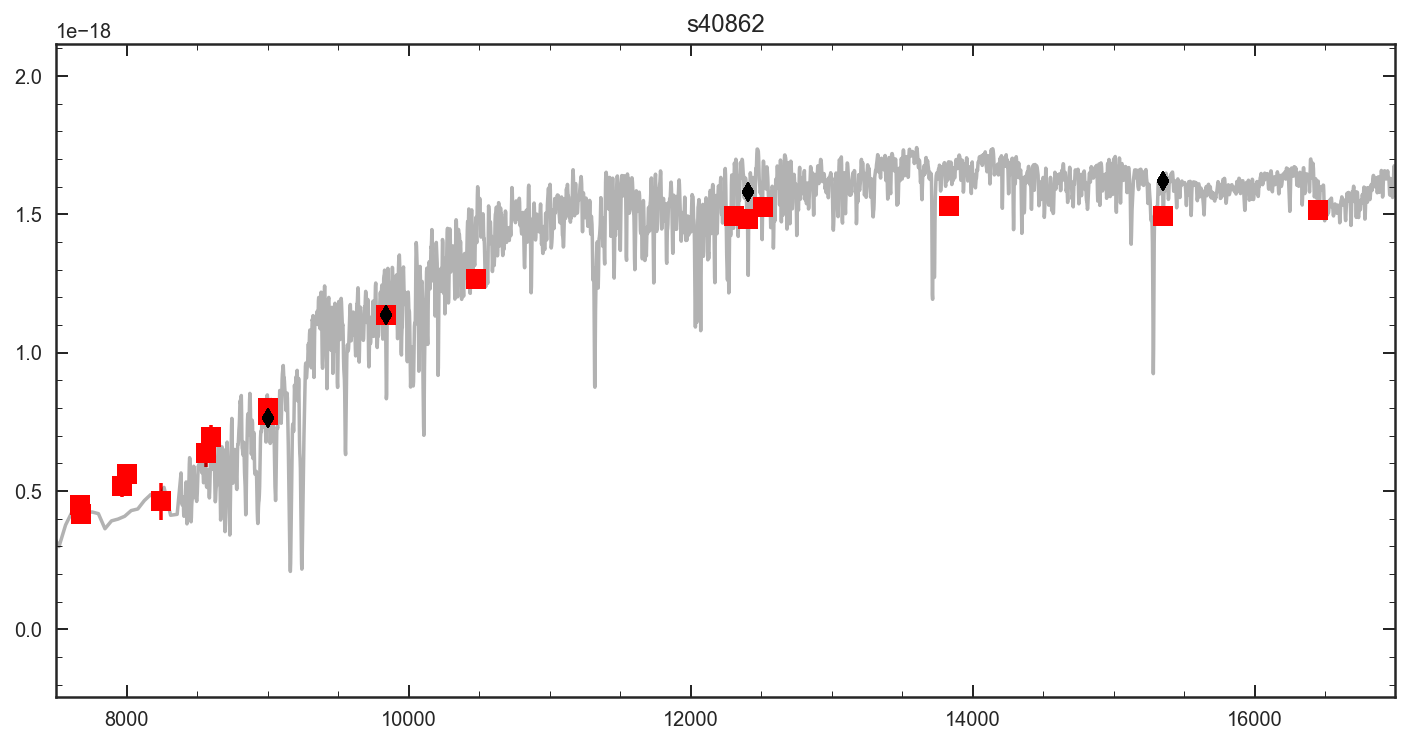

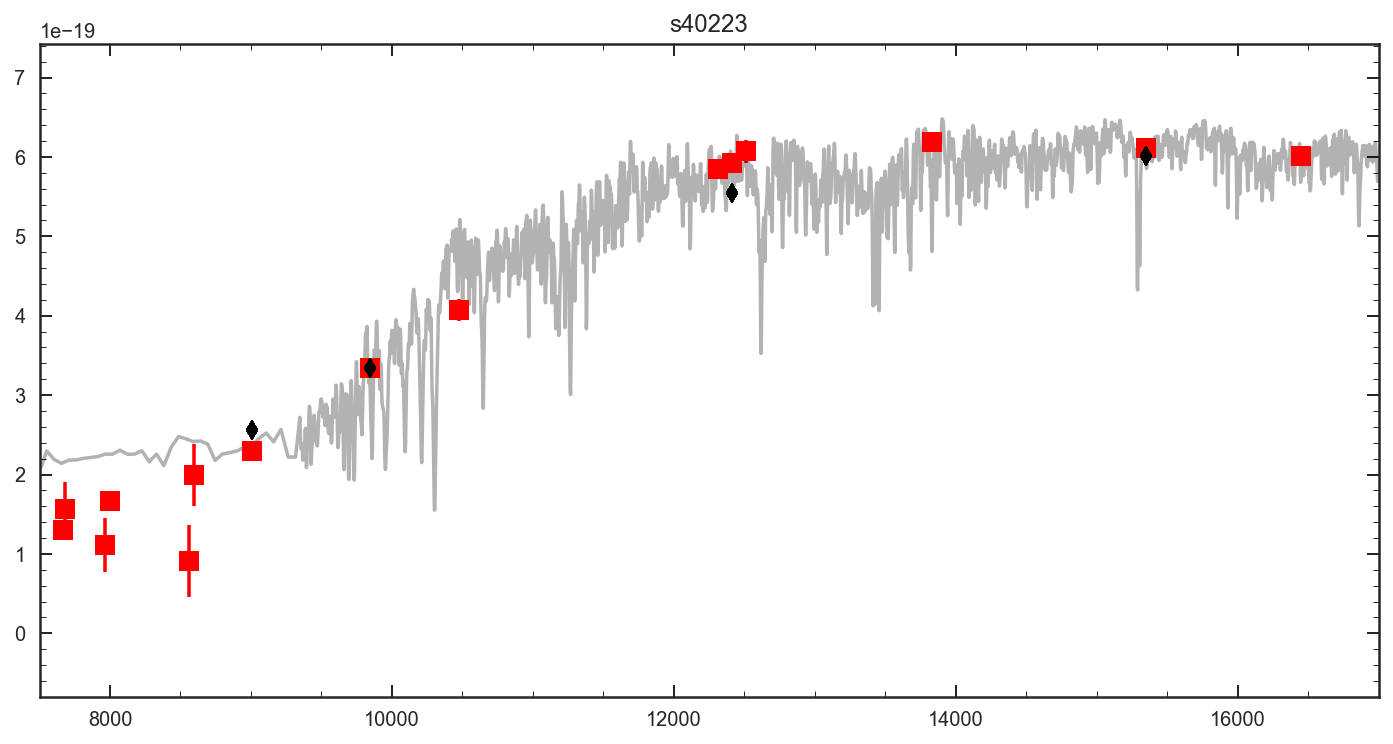

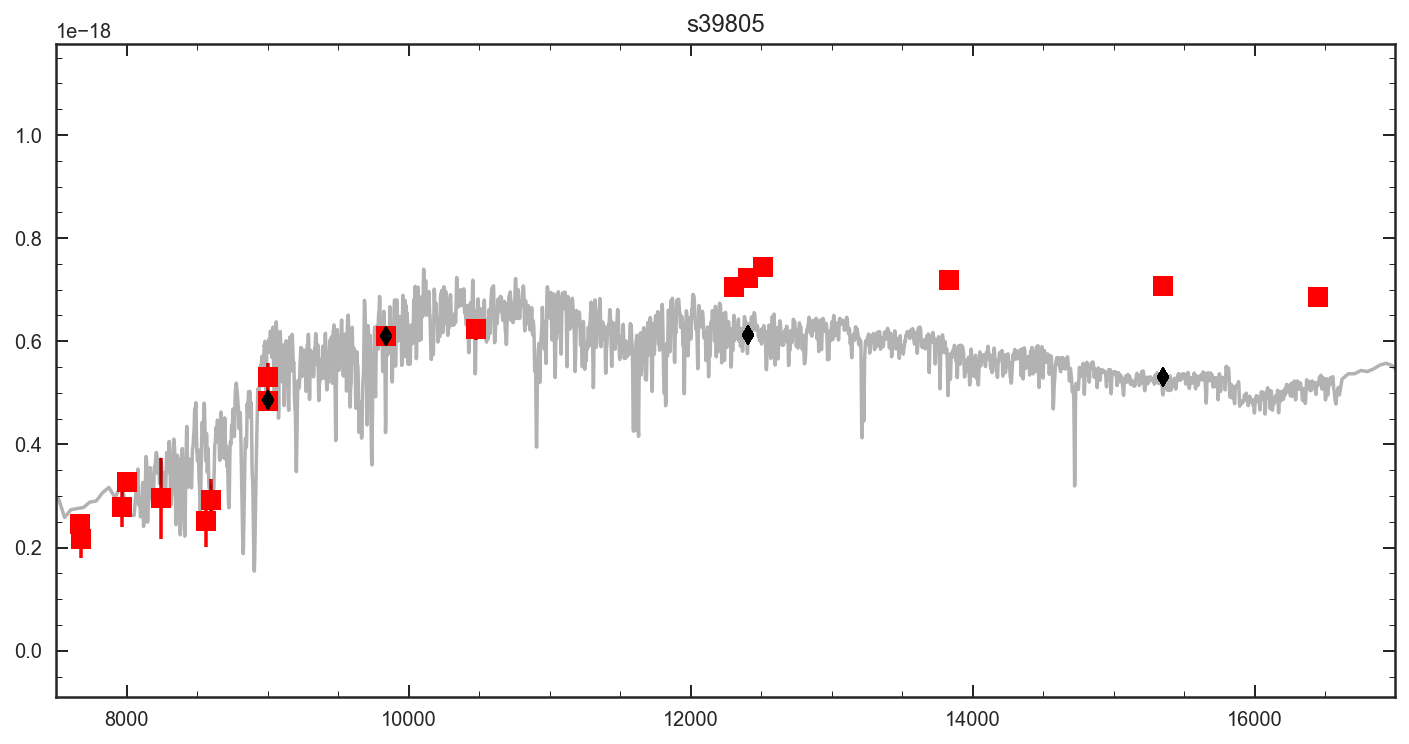

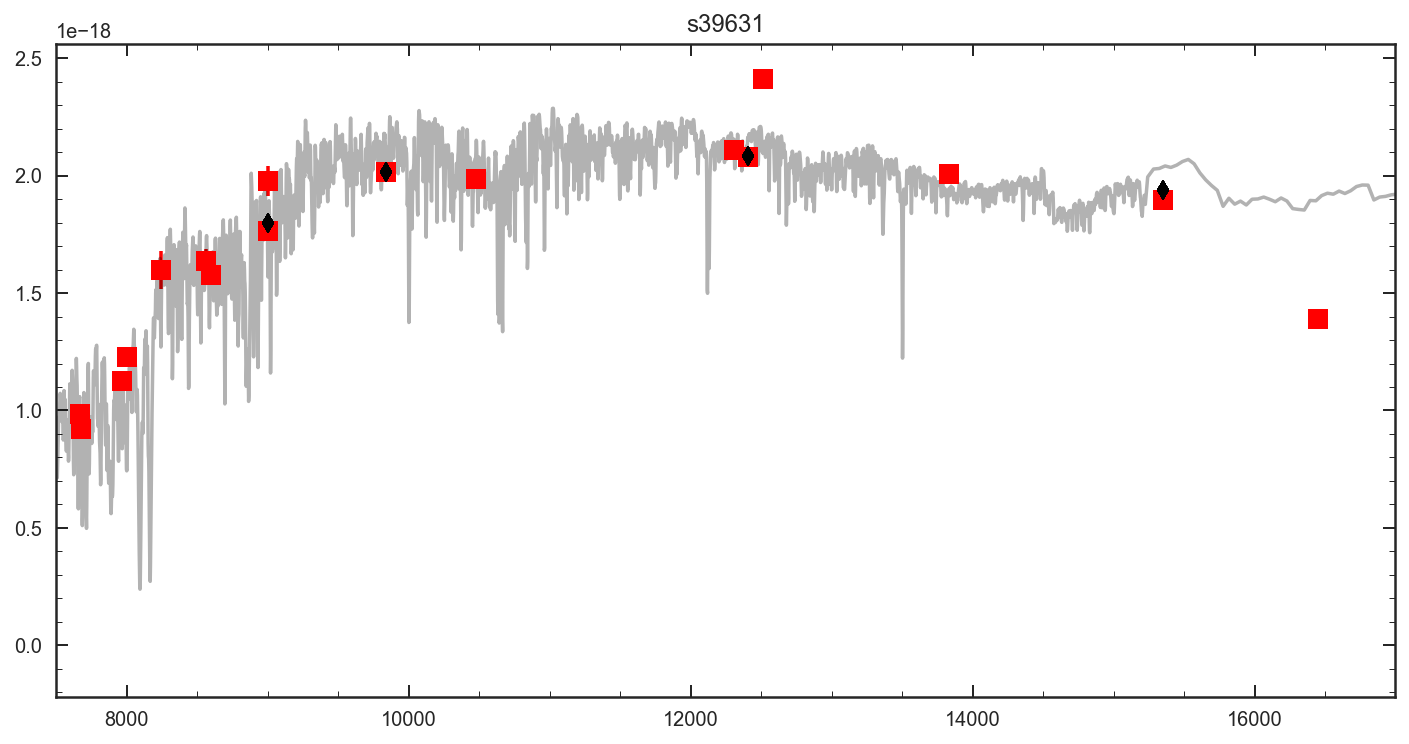

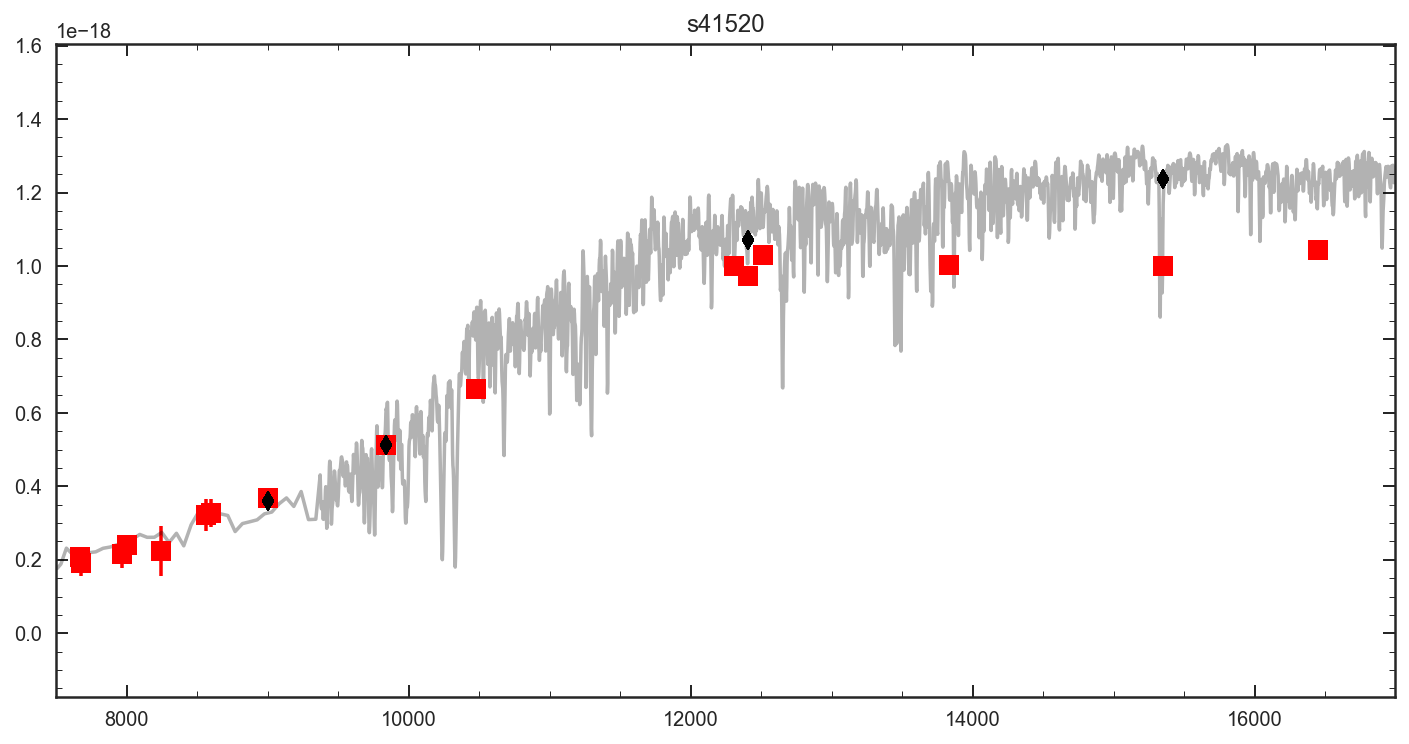

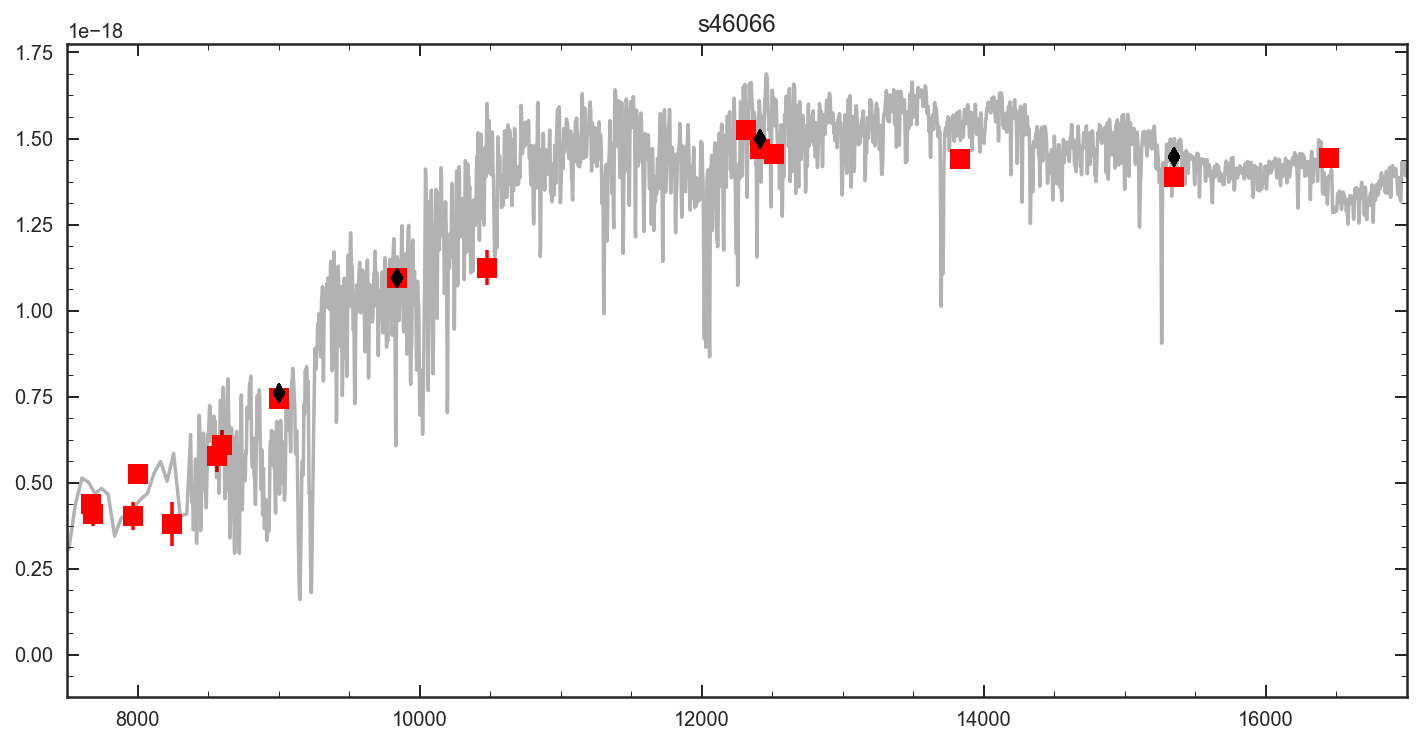

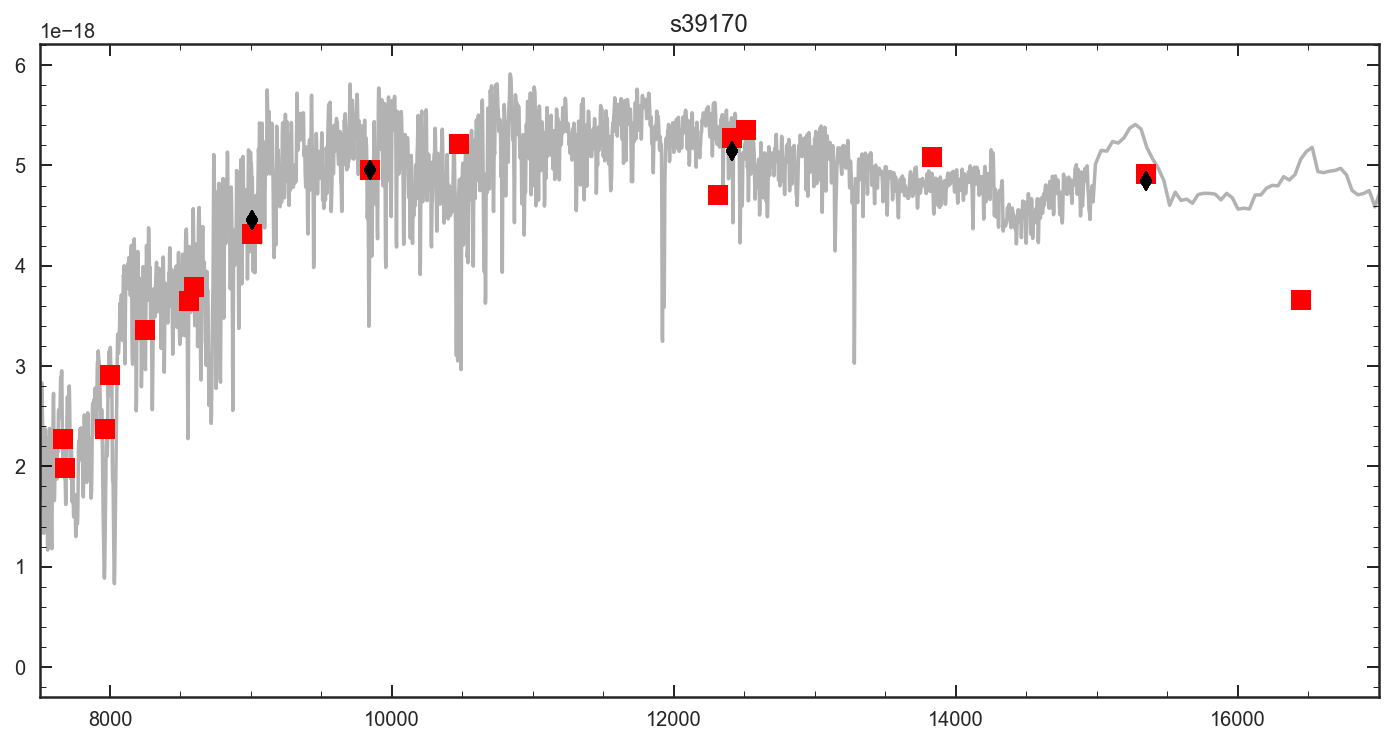

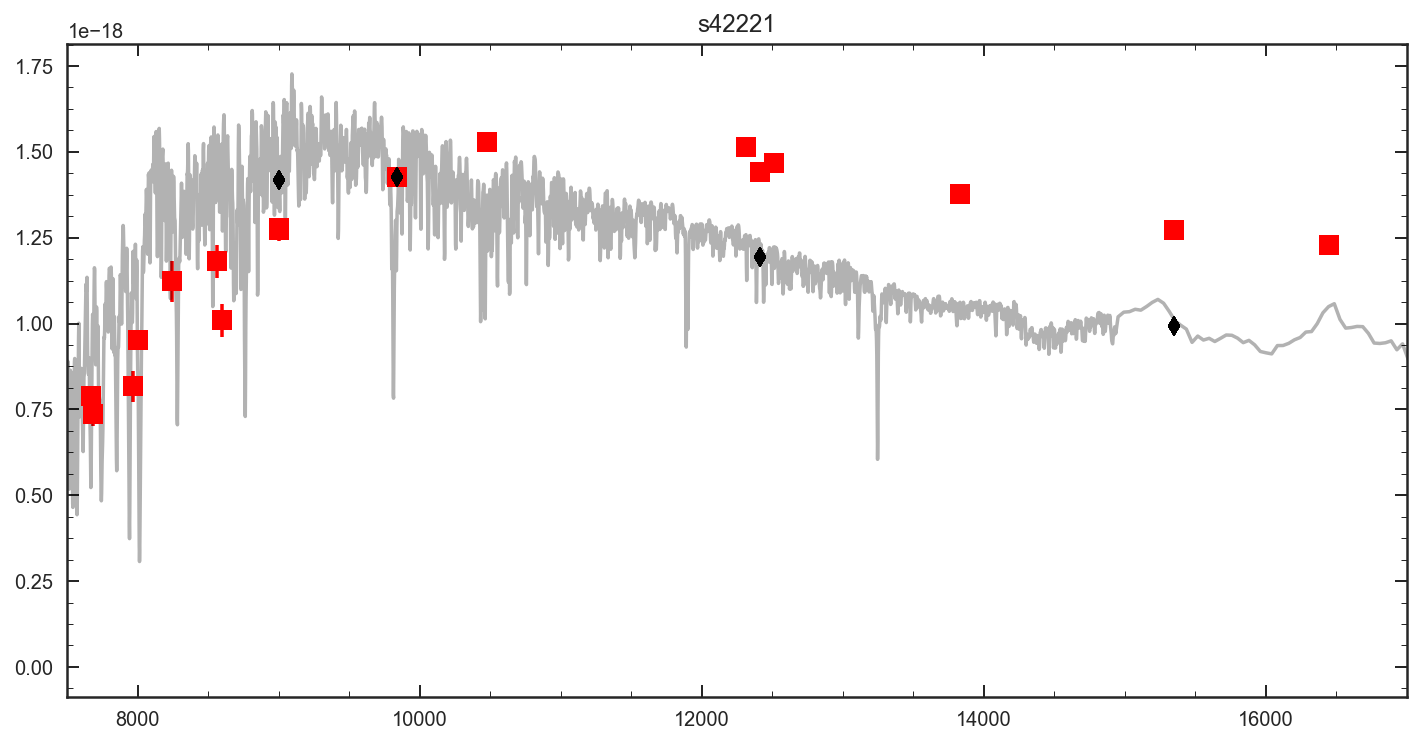

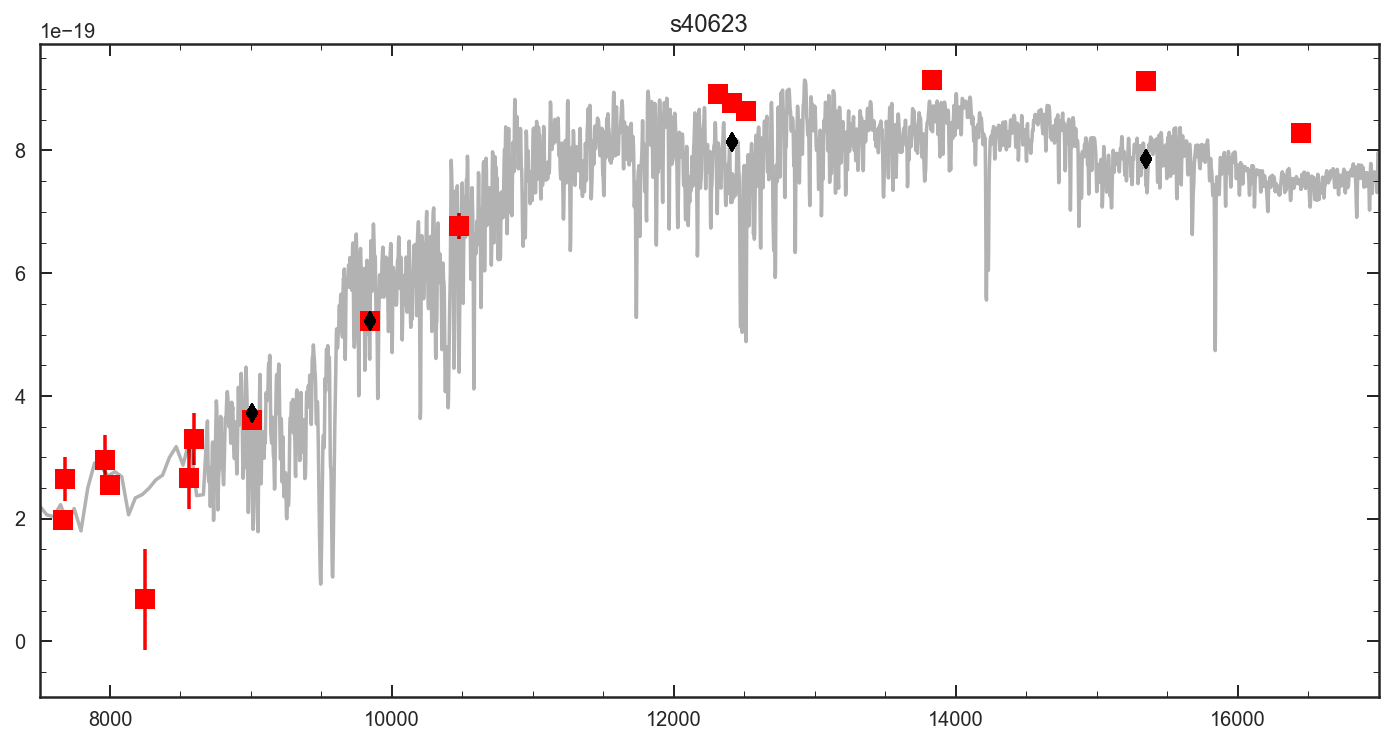

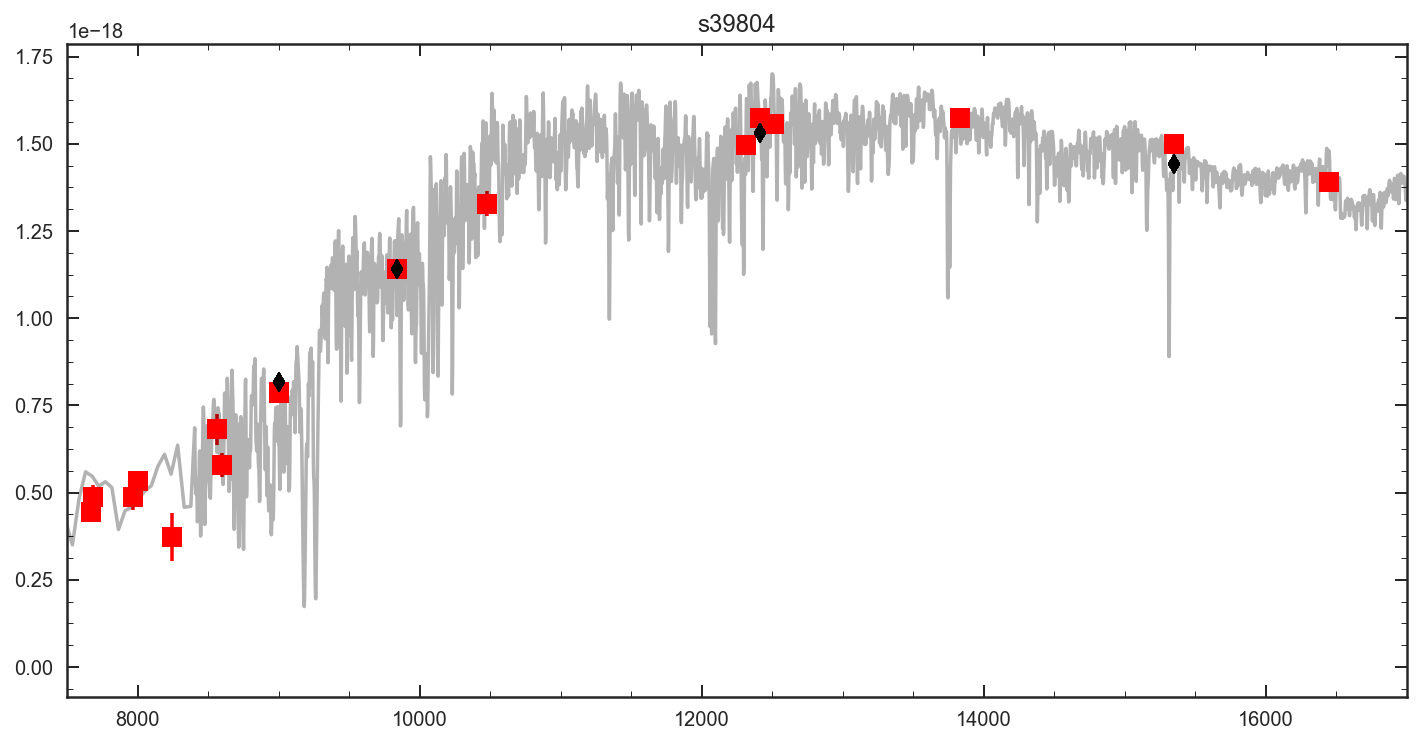

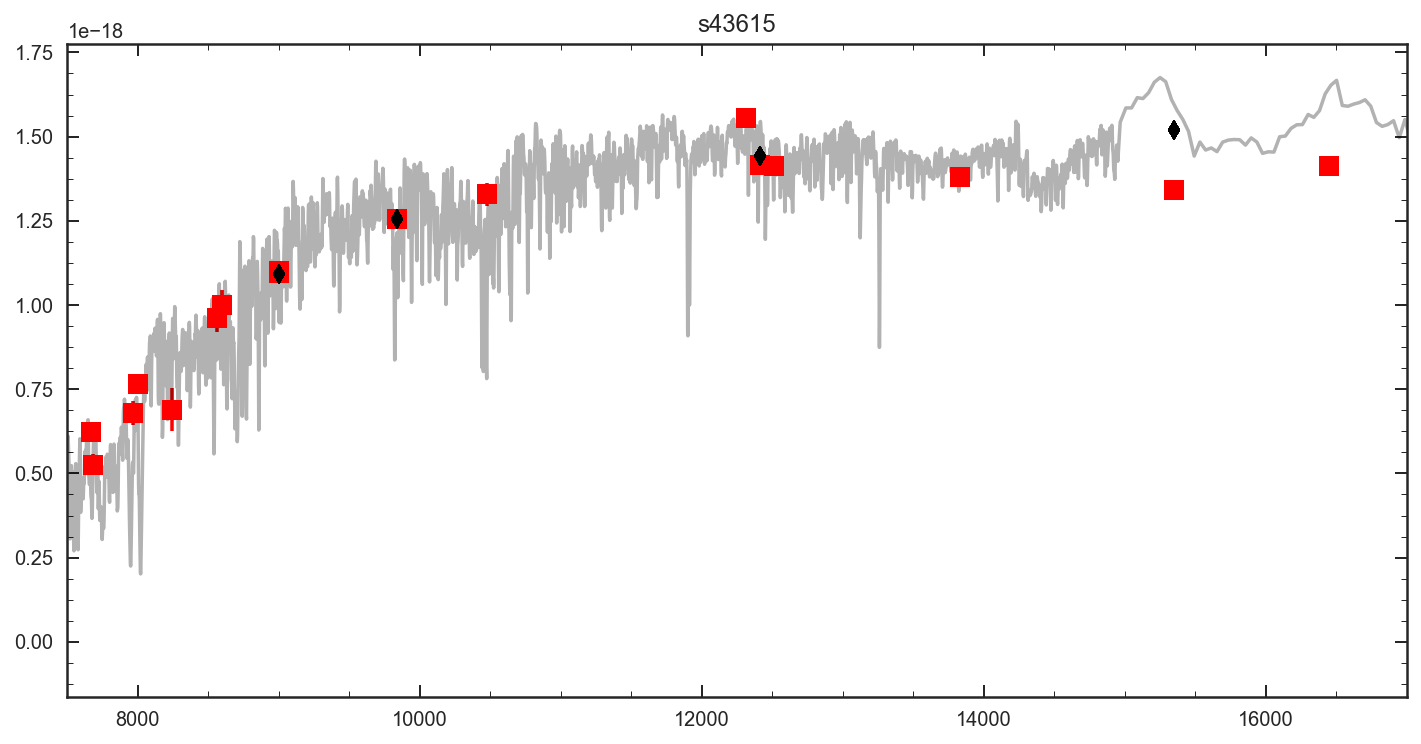

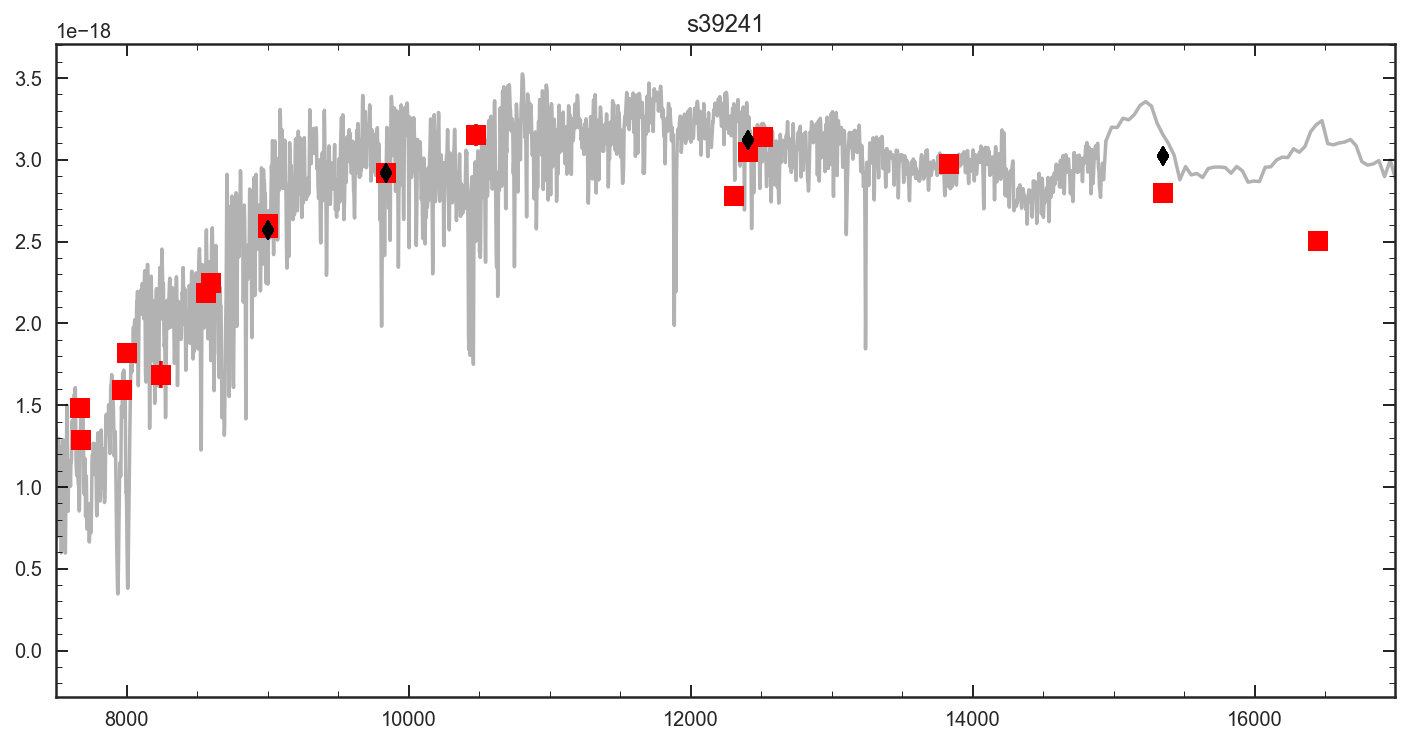

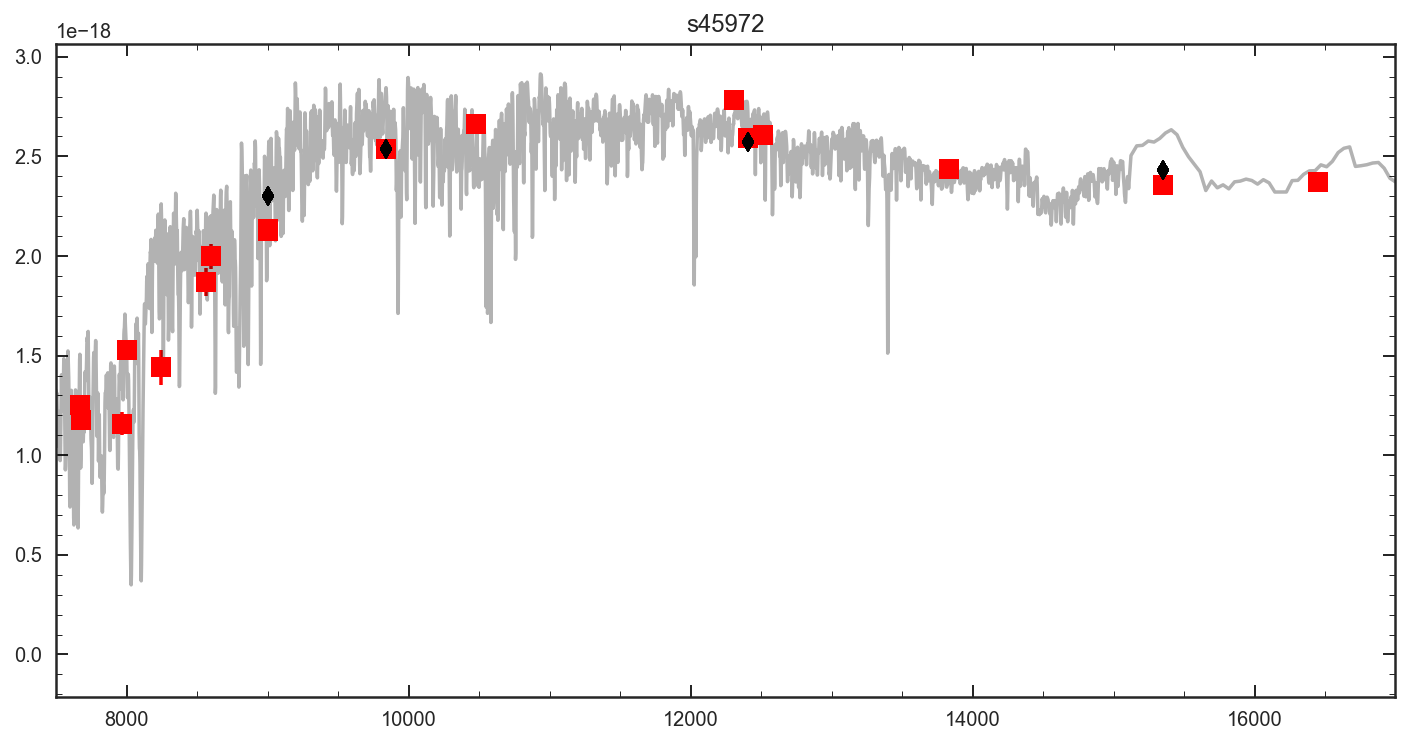

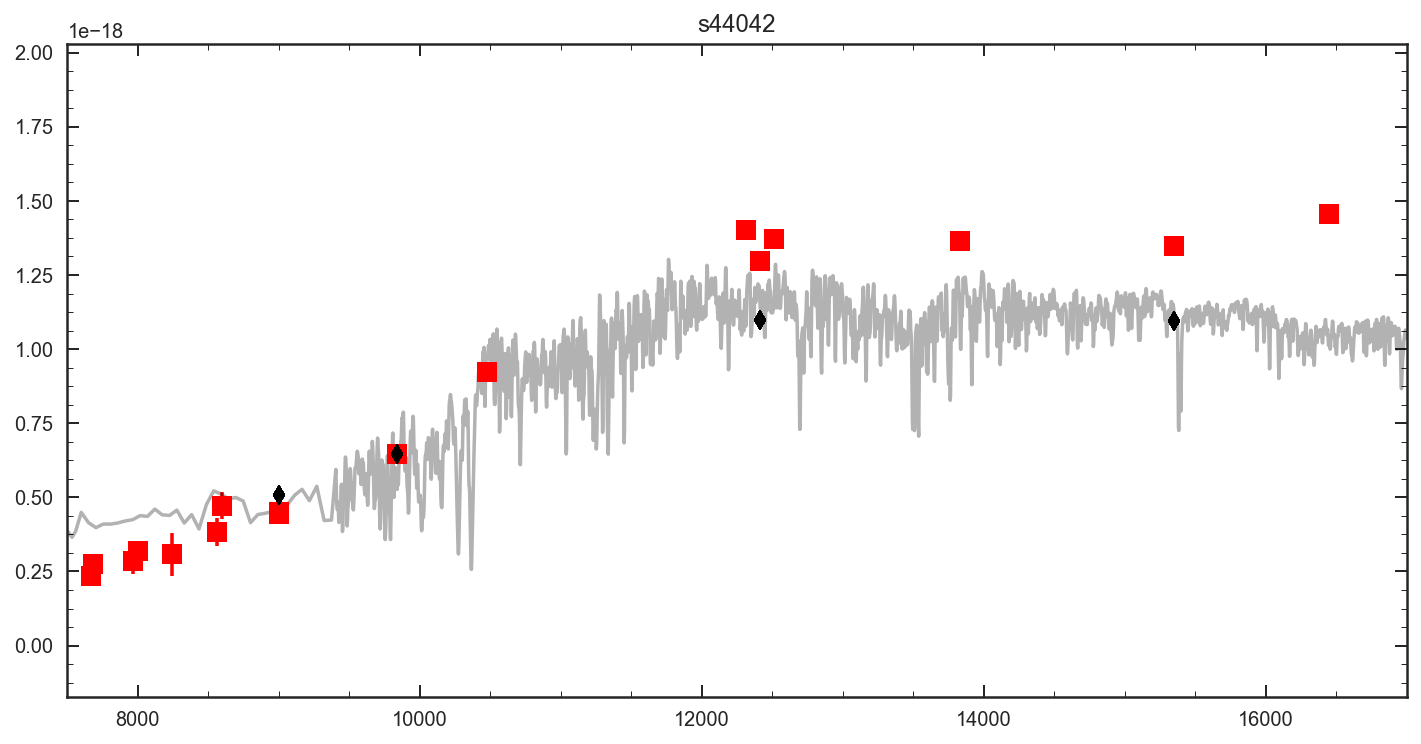

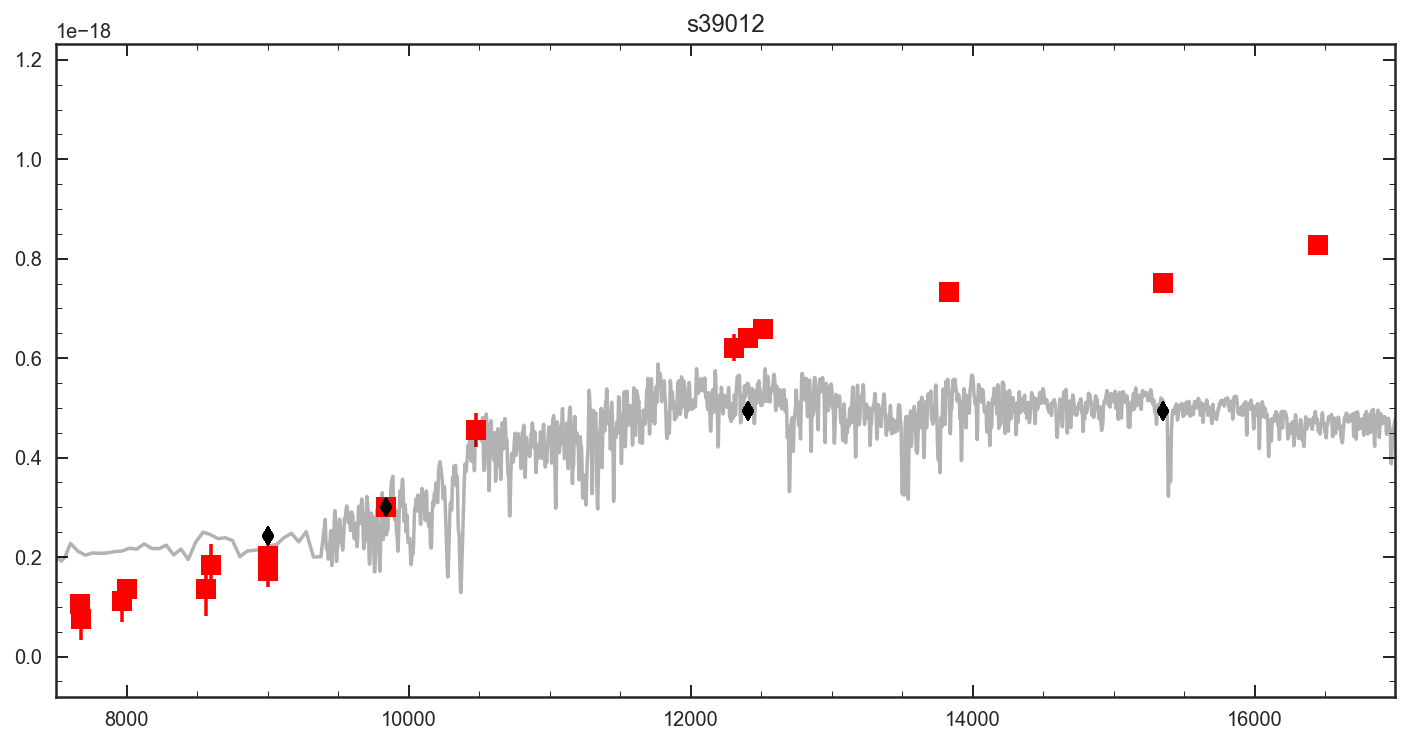

In [157]:
for i in bfDB.index:
    if bfDB.gids[i][0] == 's':
        Plot(bfDB,i,sphotdb,sf_list)

#     if bfDB.gids[i][0] == 'n':
#         Plot(bfDB,i,nphotdb,nf_list)


In [64]:
def Get_params(DB,idx):
    age_conv = np.load('../data/light_weight_scaling_3.npy')

    idm = np.where(metal == DB.Z[idx])[0]
    idtau = np.where(tau == np.round(np.log10(DB.tau[idx]) + 9,2))

    diff = np.abs(age_conv[idm,:,idtau][0][0] - DB.tx[idx])

    return metal[idm[0]], age[diff == min(diff)][0], tau[idtau[0][0]]

In [8]:
f105s = Table.read('/Users/Vince.ec/Clear_data/goodss_mosaic/goodss-F105W-astrodrizzle-v4.4_drz_sub.cat',format='ascii').to_pandas()
f105n = Table.read('/Users/Vince.ec/Clear_data/goodsn_mosaic/goodsn-F105W-astrodrizzle-v4.4_drz_sub.cat',format='ascii').to_pandas()

In [6]:
def Mag(band):
    magnitude=25-2.5*np.log10(band)
    return magnitude

def unMag(mag):
    return 10**((mag-25) / (-2.5))

In [111]:
bfDB

,bfZ,bfd,bft,bftau,bfz,gids
0,0.029,0.0,6.0,9.00,1.221,s40597
1,0.010,0.8,1.1,0.00,1.209,s40476
2,0.019,0.0,1.9,0.00,1.175,s38785
3,0.024,0.9,1.3,0.00,1.328,s40862
4,0.024,0.9,5.8,9.11,1.595,s40223
5,0.030,0.0,3.3,8.70,1.242,s39805
6,0.030,1.0,0.7,8.00,1.334,s44620
7,0.008,0.0,6.0,0.00,1.057,s39631
8,0.030,0.9,2.4,8.48,1.601,s41520
9,0.019,0.3,2.2,8.30,1.249,n21156


$\frac{\sigma}{F \ln(10)}$

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt

Text(0.5,1,'s42221')

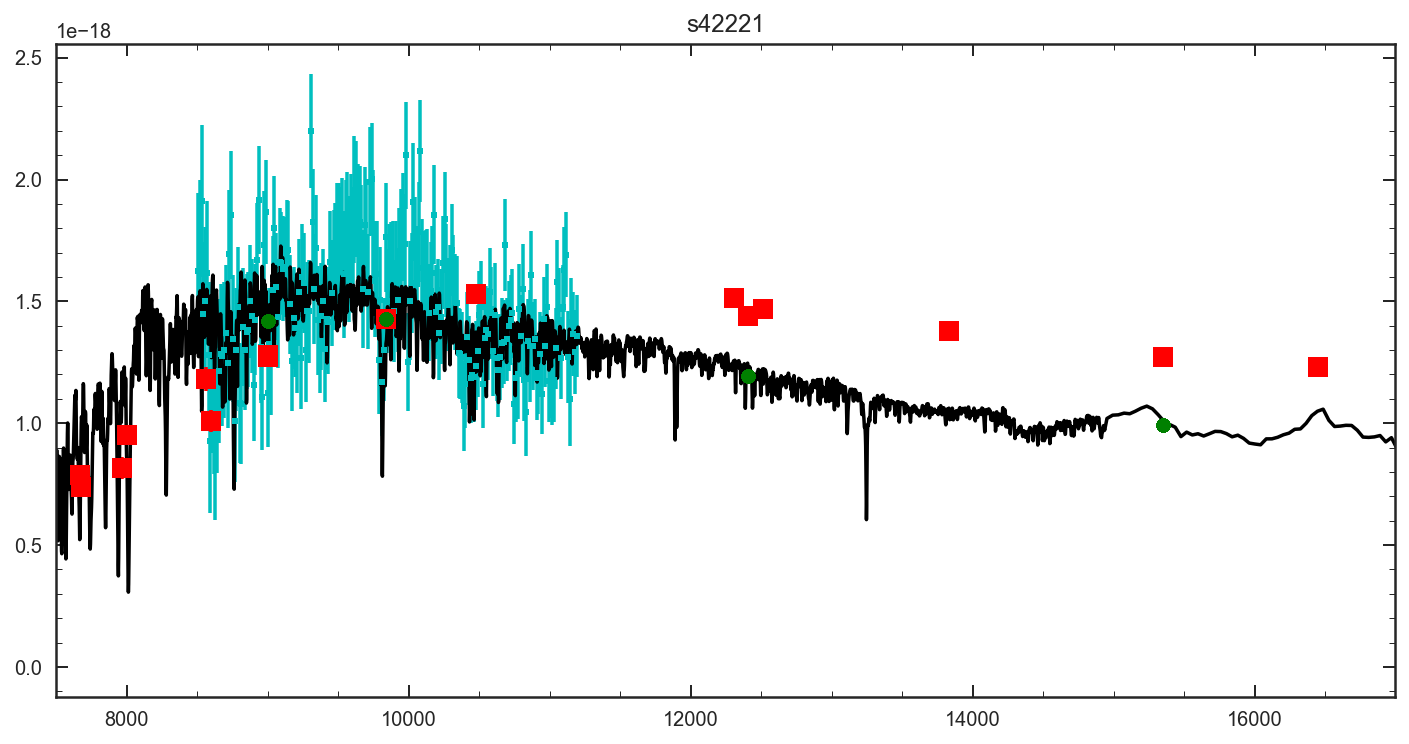

In [116]:
sp = Gen_spec(galDB.gids[24],galDB.z_grism[24],minwv=8500)
#         mp,ap,tp = Get_params(galDB,i)
#         wv,fl = np.load('/Users/Vince.ec/fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(mp,ap,tp))
idx=17
rshift =galDB.z_grism[24]

if bfDB.bftau[idx] == 0:
    wv,fl = np.load('/Users/Vince.ec/fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(
        bfDB.bfZ[idx], bfDB.bft[idx], 0))
else:
    wv,fl = np.load('/Users/Vince.ec/fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(
            bfDB.bfZ[idx], bfDB.bft[idx], bfDB.bftau[idx]))

er = np.ones(len(wv))
dust = Calzetti(bfDB.bfd[idx],wv)
dust2 = Calzetti2(bfDB.bfd[idx],wv)

for ii in range(len(dust)):
    if wv[ii] > 6300:
        dust[ii]=dust2[ii] 

fl *= dust
phot = Photometry(wv*(1+rshift),fl,er,201)
phot.Get_Sensitivity()
phot.Photo()

Clam = 3E18 / sphotdb['f_F098M'][0] **2 * 10**((-1.1)/2.5-29)
fl *= (Clam*sphotdb['f_F098M'][int(bfDB.gids[idx][1:])-1]/phot.photo)

phot = Photometry(wv*(1+rshift),fl,er,7)
phot.Get_Sensitivity()
phot.Photo()
zlam, z = [phot.eff_wv,phot.photo]

phot.Get_Sensitivity(201)
phot.Photo()
ylam, y =[phot.eff_wv,phot.photo]

phot.Get_Sensitivity(203)
phot.Photo()
jlam, j =[phot.eff_wv,phot.photo]

phot.Get_Sensitivity(205)
phot.Photo()
hlam, h =[phot.eff_wv,phot.photo]

plt.figure(figsize=[12,6])
plt.plot(wv*(1+rshift),fl,'k')
plt.errorbar(sp.gal_wv,sp.gal_fl,sp.gal_er,linestyle='None', marker='s', markersize=3, color='c')
for ii in sf_list:
    Clam = 3E18 / sphotdb[ii][0] **2 * 10**((-1.1)/2.5-29)
    if sphotdb[ii][int(bfDB.gids[i][1:])-1] > 0:
        plt.errorbar(sphotdb[ii][0],Clam*sphotdb[ii][int(bfDB.gids[idx][1:])-1],Clam*sphotdb['e' + ii[1:]][int(bfDB.gids[idx][1:])-1],
                     linestyle='None', marker='s', markersize=10, color='r')
    plt.plot([zlam,ylam,jlam,hlam],[z,y,j,h],'go',zorder=5)
plt.xlim(7500,17000)
plt.title(bfDB.gids[idx])

In [56]:
nphotdb['f_F105W'] = np.zeros(len(nphotdb))
nphotdb['e_F105W'] = np.zeros(len(nphotdb))

for i in sphotdb.index:
    if sphotdb.gids[i] != 'eff_wv':
        if sphotdb.gids[i] == 35774:
            print('skip')
        else:
            sphotdb['f_F105W'][i] = unMag(f105s.MAG_AUTO[sphotdb.gids[i] - 1])
            sphotdb['e_F105W'][i] = f105s.MAGERR_AUTO[sphotdb.gids[i] - 1] * np.log(10) * unMag(f105s.MAG_AUTO[sphotdb.gids[i] - 1])

for i in nphotdb.index:
    if nphotdb.gids[i] != 'eff_wv':
        nphotdb['f_F105W'][i] = unMag(f105n.MAG_AUTO[nphotdb.gids[i] - 1])
        nphotdb['e_F105W'][i] = f105n.MAGERR_AUTO[nphotdb.gids[i] - 1] * np.log(10) * unMag(f105n.MAG_AUTO[nphotdb.gids[i] - 1])
            
nphotdb['f_F105W'][0] = sphotdb['f_F105W'][0]
nphotdb['e_F105W'][0] = sphotdb['f_F105W'][0]

skip


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log10


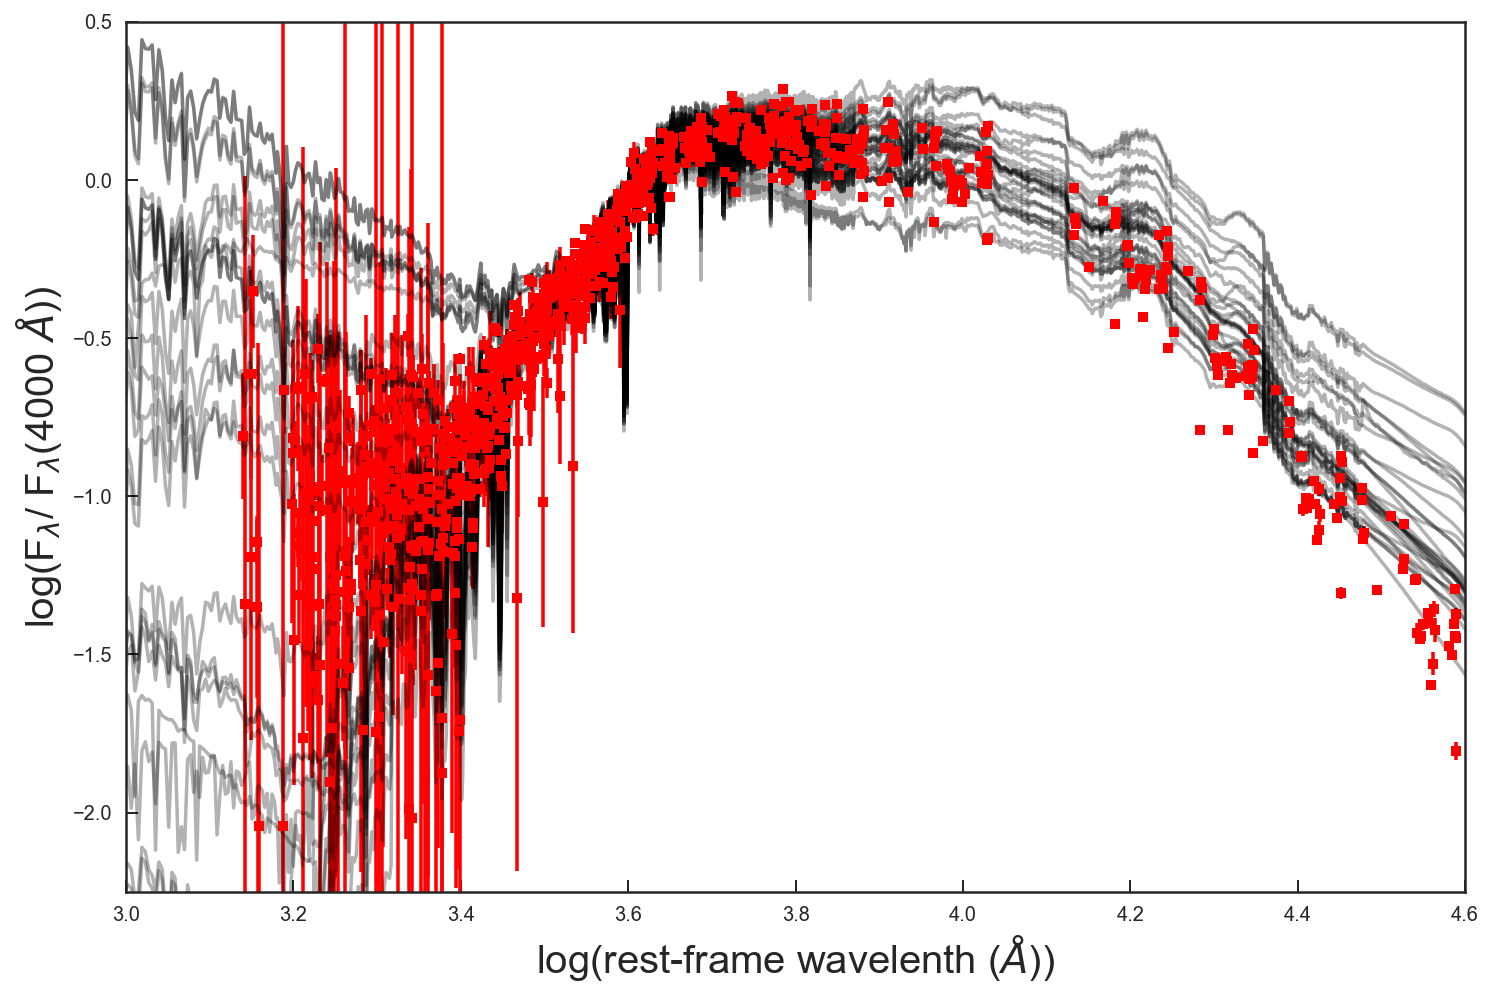

In [7]:
plt.figure(figsize=[12,8])
for i in bfDB.index:
    if bfDB.gids[i][0] == 's':
        if sphotdb['f_F105W'][int(bfDB.gids[i][1:])-1] > 0:
            rshift =galDB[galDB.gids == bfDB.gids[i]].z_grism.values[0]

            if bfDB.bftau[i] == 0:
                wv,fl = np.load(hpath + 'fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(
                    bfDB.bfZ[i], bfDB.bft[i], 0))
            else:
                wv,fl = np.load(hpath + 'fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(
                        bfDB.bfZ[i], bfDB.bft[i], bfDB.bftau[i]))

            er = np.ones(len(wv))
            dust = Calzetti(bfDB.bfd[i],wv)
            dust2 = Calzetti2(bfDB.bfd[i],wv)

            for ii in range(len(dust)):
                if wv[ii] > 6300:
                    dust[ii]=dust2[ii] 

            fl *= dust
            phot = Photometry(wv*(1+rshift),fl,er,202)
            phot.Get_Sensitivity()
            phot.Photo()

            Clam = 3E18 / sphotdb['f_F105W'][0] **2 * 10**((-1.1)/2.5-29)
            f105 = Clam*sphotdb['f_F105W'][int(bfDB.gids[i][1:])-1]
            fl *= (f105/phot.photo)
            
            d4 = interp1d(wv,fl)(4000)
#             plt.figure(figsize=[12,8])
            
            plt.plot(np.log10(wv),np.log10(fl/d4),'k',alpha=0.3)
            for ii in sf_list:
                Clam = 3E18 / sphotdb[ii][0] **2 * 10**((-1.1)/2.5-29)
                if sphotdb[ii][int(bfDB.gids[i][1:])-1] > 0:
                    plt.errorbar(np.log10(sphotdb[ii][0] / (1 + rshift)),np.log10(Clam*sphotdb[ii][int(bfDB.gids[i][1:])-1]/d4),
                                 Clam*sphotdb['e' + ii[1:]][int(bfDB.gids[i][1:])-1] / (Clam*sphotdb[ii][int(bfDB.gids[i][1:])-1] * np.log(10)),
                                 linestyle='None', marker='s', markersize=5, color='r')

#             plt.xlim(3.3,4.5)
#             plt.ylim(-2.25,0.5)
                    
    if bfDB.gids[i][0] == 'n':
        if nphotdb['f_F105W'][int(bfDB.gids[i][1:])-1] > 0:
            rshift =galDB[galDB.gids == bfDB.gids[i]].z_grism.values[0]

            if bfDB.bftau[i] == 0:
                wv,fl = np.load(hpath + 'fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(
                    bfDB.bfZ[i], bfDB.bft[i], 0))
            else:
                wv,fl = np.load(hpath + 'fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(
                        bfDB.bfZ[i], bfDB.bft[i], bfDB.bftau[i]))

            er = np.ones(len(wv))
            dust = Calzetti(bfDB.bfd[i],wv)
            dust2 = Calzetti2(bfDB.bfd[i],wv)

            for ii in range(len(dust)):
                if wv[ii] > 6300:
                    dust[ii]=dust2[ii] 

            fl *= dust
            phot = Photometry(wv*(1+rshift),fl,er,202)
            phot.Get_Sensitivity()
            phot.Photo()

            Clam = 3E18 / nphotdb['f_F105W'][0] **2 * 10**((-1.1)/2.5-29)
            f105 = Clam*nphotdb['f_F105W'][int(bfDB.gids[i][1:])-1]
            fl *= (f105/phot.photo)
            d4 = interp1d(wv,fl)(4000)
#             plt.figure(figsize=[12,8])

            plt.plot(np.log10(wv),np.log10(fl/d4),'k',alpha=0.3)
            for ii in nf_list:
                Clam = 3E18 / nphotdb[ii][0] **2 * 10**((-1.1)/2.5-29)
                if nphotdb[ii][int(bfDB.gids[i][1:])-1] > 0:
                    plt.errorbar(np.log10(nphotdb[ii][0] / (1 + rshift)),np.log10(Clam*nphotdb[ii][int(bfDB.gids[i][1:])-1]/d4),
                                 Clam*nphotdb['e' + ii[1:]][int(bfDB.gids[i][1:])-1] / (Clam*nphotdb[ii][int(bfDB.gids[i][1:])-1] * np.log(10)),
                                 linestyle='None', marker='s', markersize=5, color='r')
#             plt.xlim(3.3,4.5)
#             plt.ylim(-2.25,0.5)
plt.xlim(3.,4.6)
plt.ylim(-2.25,0.5)
plt.xlabel('log(rest-frame wavelenth ($\AA$))',fontsize=20)
plt.ylabel('log(F$_\lambda$/ F$_\lambda$(4000 $\AA$))',fontsize=20)
plt.savefig('../plots/spec_vs_phot.png',bbox_inches = 'tight')

In [3]:
bfDB = pd.read_pickle('../data/BF_no_dust.pkl')

In [4]:
bfDB

,bfZ,bft,bftau,bfz,gids
0,0.028,5.5,8.95,1.221,s40597
1,0.008,1.4,0.00,1.209,s40476
2,0.019,2.0,0.00,1.175,s38785
3,0.030,3.0,8.30,1.328,s40862
4,0.024,1.6,8.30,1.595,s40223
5,0.030,3.3,8.70,1.242,s39805
6,0.030,1.0,8.00,1.334,s44620
7,0.008,6.0,0.00,1.057,s39631
8,0.008,1.4,0.00,1.606,s41520
9,0.015,3.2,8.48,1.249,n21156


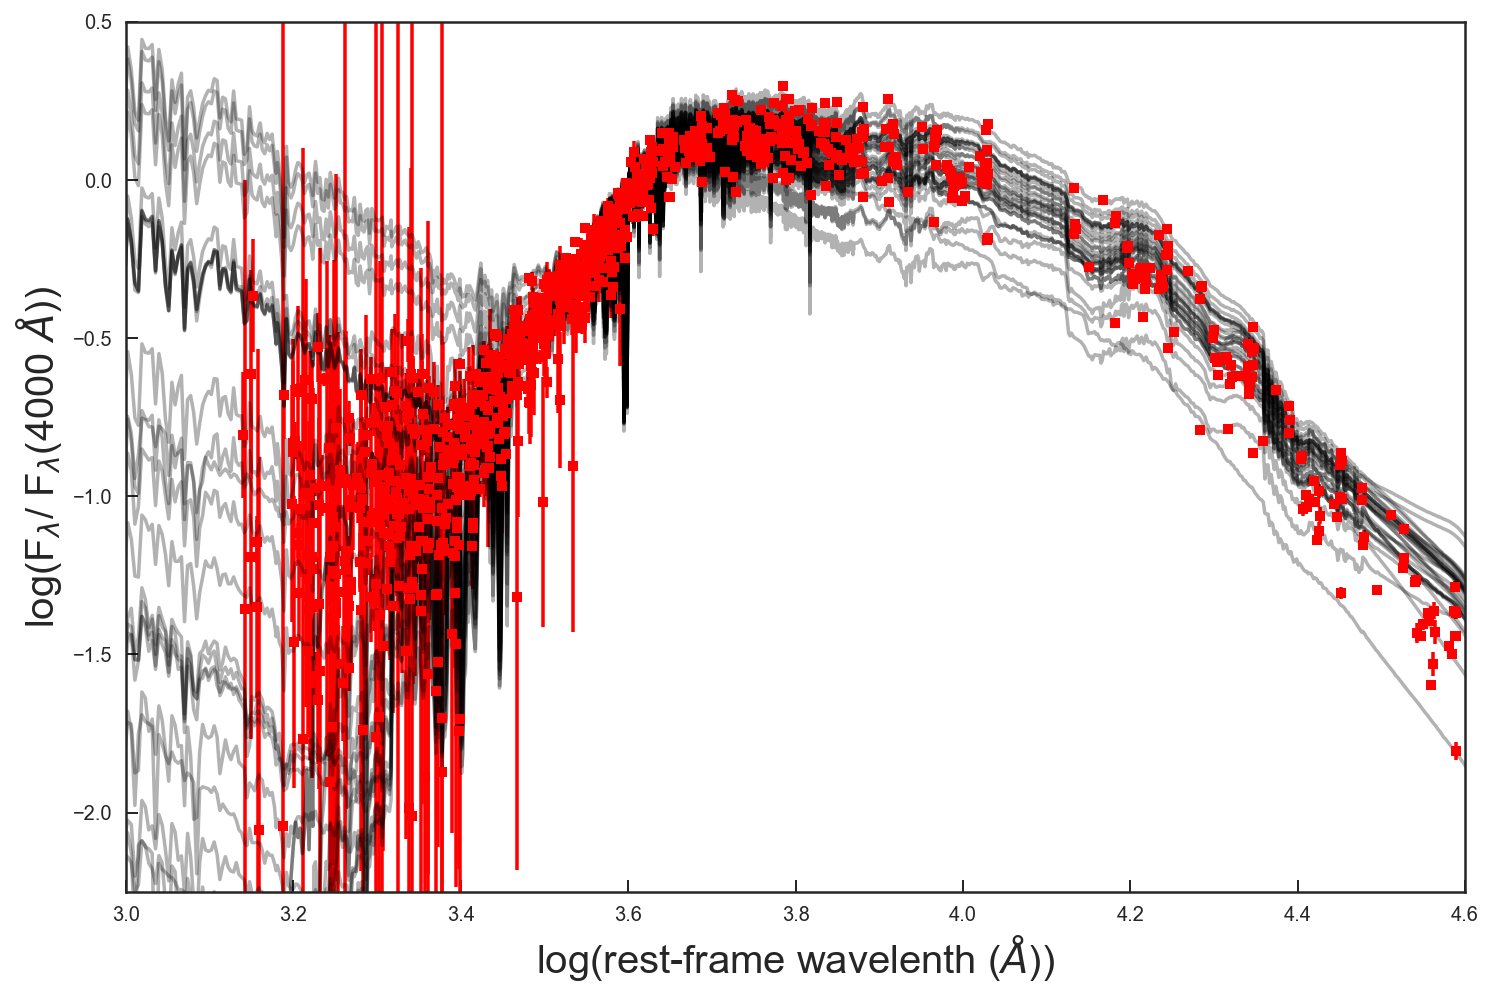

In [9]:
plt.figure(figsize=[12,8])
for i in bfDB.index:
    if bfDB.gids[i][0] == 's':
        if sphotdb['f_F105W'][int(bfDB.gids[i][1:])-1] > 0:
            rshift =galDB[galDB.gids == bfDB.gids[i]].z_grism.values[0]

            if bfDB.bftau[i] == 0:
                wv,fl = np.load(hpath + 'fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(
                    bfDB.bfZ[i], bfDB.bft[i], 0))
            else:
                wv,fl = np.load(hpath + 'fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(
                        bfDB.bfZ[i], bfDB.bft[i], bfDB.bftau[i]))

            er = np.ones(len(wv))
#             dust = Calzetti(bfDB.bfd[i],wv)
#             dust2 = Calzetti2(bfDB.bfd[i],wv)

#             for ii in range(len(dust)):
#                 if wv[ii] > 6300:
#                     dust[ii]=dust2[ii] 

#             fl *= dust
            phot = Photometry(wv*(1+rshift),fl,er,202)
            phot.Get_Sensitivity()
            phot.Photo()

            Clam = 3E18 / sphotdb['f_F105W'][0] **2 * 10**((-1.1)/2.5-29)
            f105 = Clam*sphotdb['f_F105W'][int(bfDB.gids[i][1:])-1]
            fl *= (f105/phot.photo)
            
            d4 = interp1d(wv,fl)(4000)
#             plt.figure(figsize=[12,8])
            
            plt.plot(np.log10(wv),np.log10(fl/d4),'k',alpha=0.3)
            for ii in sf_list:
                Clam = 3E18 / sphotdb[ii][0] **2 * 10**((-1.1)/2.5-29)
                if sphotdb[ii][int(bfDB.gids[i][1:])-1] > 0:
                    plt.errorbar(np.log10(sphotdb[ii][0] / (1 + rshift)),np.log10(Clam*sphotdb[ii][int(bfDB.gids[i][1:])-1]/d4),
                                 Clam*sphotdb['e' + ii[1:]][int(bfDB.gids[i][1:])-1] / (Clam*sphotdb[ii][int(bfDB.gids[i][1:])-1] * np.log(10)),
                                 linestyle='None', marker='s', markersize=5, color='r')

#             plt.xlim(3.3,4.5)
#             plt.ylim(-2.25,0.5)
                    
    if bfDB.gids[i][0] == 'n':
        if nphotdb['f_F105W'][int(bfDB.gids[i][1:])-1] > 0:
            rshift =galDB[galDB.gids == bfDB.gids[i]].z_grism.values[0]

            if bfDB.bftau[i] == 0:
                wv,fl = np.load(hpath + 'fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(
                    bfDB.bfZ[i], bfDB.bft[i], 0))
            else:
                wv,fl = np.load(hpath + 'fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(
                        bfDB.bfZ[i], bfDB.bft[i], bfDB.bftau[i]))

            er = np.ones(len(wv))
#             dust = Calzetti(bfDB.bfd[i],wv)
#             dust2 = Calzetti2(bfDB.bfd[i],wv)

#             for ii in range(len(dust)):
#                 if wv[ii] > 6300:
#                     dust[ii]=dust2[ii] 

#             fl *= dust
            phot = Photometry(wv*(1+rshift),fl,er,202)
            phot.Get_Sensitivity()
            phot.Photo()

            Clam = 3E18 / nphotdb['f_F105W'][0] **2 * 10**((-1.1)/2.5-29)
            f105 = Clam*nphotdb['f_F105W'][int(bfDB.gids[i][1:])-1]
            fl *= (f105/phot.photo)
            d4 = interp1d(wv,fl)(4000)
#             plt.figure(figsize=[12,8])

            plt.plot(np.log10(wv),np.log10(fl/d4),'k',alpha=0.3)
            for ii in nf_list:
                Clam = 3E18 / nphotdb[ii][0] **2 * 10**((-1.1)/2.5-29)
                if nphotdb[ii][int(bfDB.gids[i][1:])-1] > 0:
                    plt.errorbar(np.log10(nphotdb[ii][0] / (1 + rshift)),np.log10(Clam*nphotdb[ii][int(bfDB.gids[i][1:])-1]/d4),
                                 Clam*nphotdb['e' + ii[1:]][int(bfDB.gids[i][1:])-1] / (Clam*nphotdb[ii][int(bfDB.gids[i][1:])-1] * np.log(10)),
                                 linestyle='None', marker='s', markersize=5, color='r')
#             plt.xlim(3.3,4.5)
#             plt.ylim(-2.25,0.5)
plt.xlim(3.,4.6)
plt.ylim(-2.25,0.5)
plt.xlabel('log(rest-frame wavelenth ($\AA$))',fontsize=20)
plt.ylabel('log(F$_\lambda$/ F$_\lambda$(4000 $\AA$))',fontsize=20)
plt.savefig('../plots/spec_vs_phot_nodust.png',bbox_inches = 'tight')

In [61]:
sphotdb.columns

Index(['e_B', 'e_F098M', 'e_F105W', 'e_F125W', 'e_F140W', 'e_F160W', 'e_F435W',
       'e_F606W', 'e_F606Wcand', 'e_F775W', 'e_F814Wcand', 'e_F850LP',
       'e_F850LPcand', 'e_H', 'e_I', 'e_IA427', 'e_IA445', 'e_IA464',
       'e_IA484', 'e_IA505', 'e_IA527', 'e_IA550', 'e_IA574', 'e_IA598',
       'e_IA624', 'e_IA651', 'e_IA679', 'e_IA709', 'e_IA738', 'e_IA767',
       'e_IA797', 'e_IA827', 'e_IA856', 'e_IRAC1', 'e_IRAC2', 'e_IRAC3',
       'e_IRAC4', 'e_J', 'e_Ks', 'e_R', 'e_Rc', 'e_U', 'e_U38', 'e_U50', 'e_V',
       'e_tenisJ', 'e_tenisK', 'f_B', 'f_F098M', 'f_F105W', 'f_F125W',
       'f_F140W', 'f_F160W', 'f_F435W', 'f_F606W', 'f_F606Wcand', 'f_F775W',
       'f_F814Wcand', 'f_F850LP', 'f_F850LPcand', 'f_H', 'f_I', 'f_IA427',
       'f_IA445', 'f_IA464', 'f_IA484', 'f_IA505', 'f_IA527', 'f_IA550',
       'f_IA574', 'f_IA598', 'f_IA624', 'f_IA651', 'f_IA679', 'f_IA709',
       'f_IA738', 'f_IA767', 'f_IA797', 'f_IA827', 'f_IA856', 'f_IRAC1',
       'f_IRAC2', 'f_IRAC3', 'f_IRAC4'

In [143]:
def Colors(BFDB,idx,photdb,f_list):
    zy, jh, zyo, jho = [-99,-99,-99,-99]
    if photdb['f_F098M'][int(BFDB.gids[idx][1:])-1] > 0:
        rshift =galDB[galDB.gids == BFDB.gids[idx]].z_grism.values[0]

        if BFDB.bftau[idx] == 0:
            wv,fl = np.load('/Users/Vince.ec/fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(
                BFDB.bfZ[idx], BFDB.bft[idx], 0))
        else:
            wv,fl = np.load('/Users/Vince.ec/fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(
                    BFDB.bfZ[idx], BFDB.bft[idx], BFDB.bftau[idx]))

        er = np.ones(len(wv))
        dust = Calzetti(BFDB.bfd[idx],wv)
        dust2 = Calzetti2(BFDB.bfd[idx],wv)

        for ii in range(len(dust)):
            if wv[ii] > 6300:
                dust[ii]=dust2[ii] 

        fl *= dust
        phot = Photometry(wv*(1+rshift),fl,er,201)
        phot.Get_Sensitivity()
        phot.Photo()

        Clam = 3E18 / photdb['f_F098M'][0] **2 * 10**((-1.1)/2.5-29)
        fl *= (Clam*photdb['f_F098M'][int(BFDB.gids[idx][1:])-1]/phot.photo)

        phot = Photometry(wv*(1+rshift),fl,er,7)
        phot.Get_Sensitivity()
        phot.Photo()

        #z-850-7, y-098-201, j-125-203, h-160-205

        zlam, z = [phot.eff_wv,phot.photo]

        phot.Get_Sensitivity(201)
        phot.Photo()
        ylam, y =[phot.eff_wv,phot.photo]

        phot.Get_Sensitivity(203)
        phot.Photo()
        jlam, j =[phot.eff_wv,phot.photo]

        phot.Get_Sensitivity(205)
        phot.Photo()
        hlam, h =[phot.eff_wv,phot.photo]

        Clam = (3E18 / photdb['f_F850LP'][0] **2 * 10**((-1.1)/2.5-29))

        
        zobs = photdb['f_F850LP'][int(BFDB.gids[idx][1:])-1] *(3E18 / photdb['f_F850LP'][0] **2 * 10**((-1.1)/2.5-29))
        yobs = photdb['f_F098M'][int(BFDB.gids[idx][1:])-1] *(3E18 / photdb['f_F098M'][0] **2 * 10**((-1.1)/2.5-29))
        jobs = photdb['f_F125W'][int(BFDB.gids[idx][1:])-1] *(3E18 / photdb['f_F125W'][0] **2 * 10**((-1.1)/2.5-29))
        hobs = photdb['f_F160W'][int(BFDB.gids[idx][1:])-1] *(3E18 / photdb['f_F160W'][0] **2 * 10**((-1.1)/2.5-29))
        
        zy = Mag(z) - Mag(y)
        jh = Mag(j) - Mag(h)
        zyo = Mag(zobs) - Mag(yobs)
        jho = Mag(jobs) - Mag(hobs)
    return zy, jh, zyo, jho

In [145]:
zy,jh,zyo,jho =[[],[],[],[]]

for i in bfDB.index:
    if bfDB.gids[i][0] == 's':
        c1,c2,c3,c4 = Colors(bfDB,i,sphotdb,sf_list)
        zy.append(c1)
        jh.append(c2)        
        zyo.append(c3)        
        jho.append(c4)        

In [146]:
zy = np.array(zy)[np.array(zy) != -99]
jh = np.array(jh)[np.array(jh) != -99]
zyo = np.array(zyo)[np.array(zyo) != -99]
jho = np.array(jho)[np.array(jho) != -99]


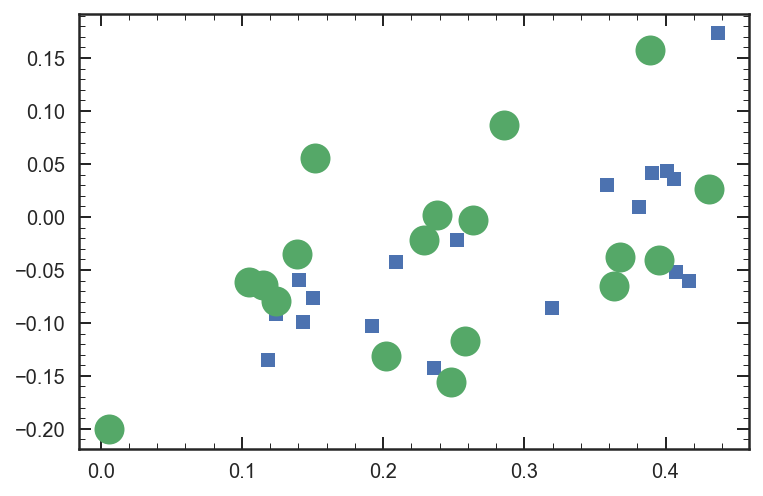

In [159]:

# for i in range(len(zyo)):
#     plt.plot([zyo,zy],[jho,jh],'k')
plt.plot(zyo,jho,'s')
plt.plot(zy,jh,'o',ms=15)

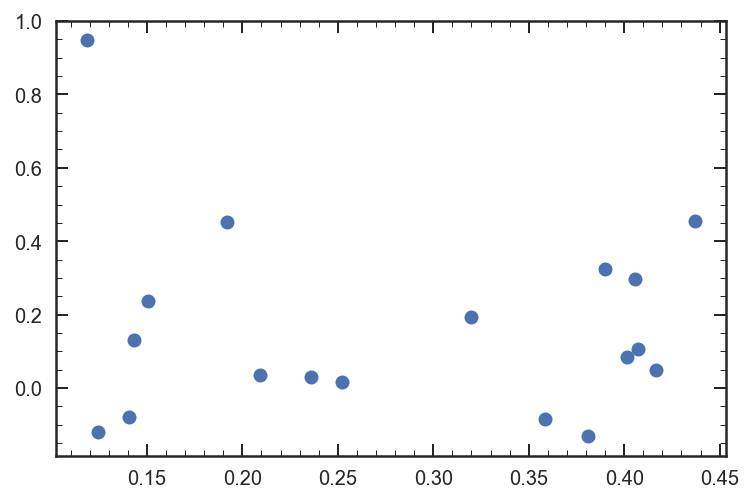

In [151]:
plt.plot(zyo,(zyo - zy)/zyo,'o')

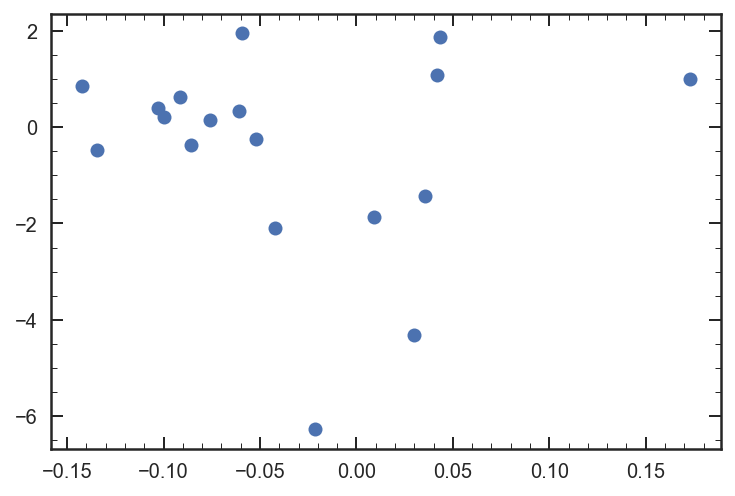

In [152]:
plt.plot(jho,(jho - jh)/jho,'o')

In [29]:
5336464/553784

9.636363636363637

In [43]:
np.repeat([dst['0.0']], len(metal)*len(age)*len(tau), axis=0).reshape(
    [len(dst['0.0'])*len(metal)*len(age)*len(tau), len(sp.gal_wv)]).shape

(553784, 256)

# 11 * len(metal)*len(age)*len(tau)

In [31]:

def Gen_dust_minigrid(fit_wv,rshift):
    dust_dict = {}
    Av = np.round(np.arange(0, 1.1, 0.1),1)
    for i in range(len(Av)):
        key = str(Av[i])
        minigrid = np.zeros([len(rshift),len(fit_wv)])
        for ii in range(len(rshift)):
            minigrid[ii] = Calzetti(Av[i],fit_wv / (1 + rshift[ii]))
        dust_dict[key] = minigrid
    return dust_dict

In [32]:
sp = Gen_spec('s39170',1.023)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt

In [33]:
dst = Gen_dust_minigrid(sp.gal_wv,np.arange(1.11,1.131,0.002))

In [39]:
dst['0.0'].shape

(11, 256)

In [44]:
106*50344

5336464

In [45]:
50344*11

553784